# Neural Network in numpy

In [1]:
from copy import deepcopy

import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

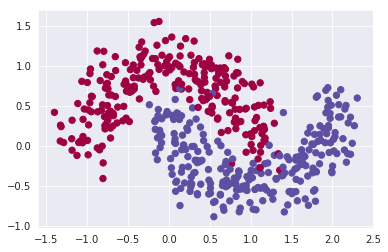

In [2]:
# Get some data

np.random.seed(13)
size = 500

X, Y = sklearn.datasets.make_moons(size, noise=0.20)

# Some preparation
x1 = X[:, 0]
x2 = X[:, 1]
x = np.vstack([x1, x2])
x = x.reshape(2, 1, size)
y = Y.reshape(1, 1, size)

# Plot our data
plt.scatter(x1, x2, s=40, c=Y, cmap=plt.cm.Spectral)

In [3]:
# Utils:
def print_shape(arr, name=None):
    """to get shape"""
    print(f'{name} shape: {arr.shape}')

In [4]:
def heaviside(z):
    """Simple activation"""
    return np.where(z >=0, 1, 0)


def loss(y_hat, y):
    """BCE"""
    return -y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)


def sigmoid(z):
    """Sigmoid activation"""
    return 1 / (1 + np.exp(-z))


class Linear:
    """FC layer"""

    def __init__(self, m, h):
        """m - number of features
           h - number of hidden units
        """
        # initilize weights and bias randomly:
        self.w = np.random.random_sample((h, m))
        self.b = np.zeros((h, 1))

    def params(self):
        """Return papams values"""
        return self.w, self.b
    
    def __call__(self, x):
        """To call
           x - input of shape of (m, n)
           z - shape (h, n)
        """
        z = self.w @ x + self.b
        return z


class Model:
    """Basic parent class for models"""

    def __init__(self):
        raise NotImplementedError

    def forward(self, x):
        """Forward pass"""
        raise NotImplementedError
   
    def backward(self):
        """Backward pass, computes gradients"""
        raise NotImplementedError
        
    def update(self):
        """Updates weights"""
        raise NotImplementedError

    def __call__(self, x):
        """Calls forward method and returns result of computation"""
        result = self.forward(x)
        return result


class Neuron(Model):
    """Single Neuron model"""

    def __init__(self):
        self.grad = 0.0
        self.linear1 = Linear(2, 1)

    def forward(self, x):
        self.x = x
        z = self.linear1(x)
        a = sigmoid(z)
#         print(a)
        return a

    def backward(self, y_hat, y):
        self.grad = (y_hat - y)

    def update(self, lr=0.01):
        self.linear1.w -= self.grad @ self.x.T * lr
        self.linear1.b -= np.sum(self.grad, axis=1, keepdims=True) * lr
        self.grad = 0.0
        
    def predict(self, x):
        y_hat = self.forward(x)
        predictions = y_hat > 0.5
        return predictions
        
        

class TwoLayers(Model):

    def __init__(self):
        self.dz2 = 0.0
        self.dw2 = 0.0
        self.db2 = 0.0
        self.dz1 = 0.0
        self.dw1 = 0.0
        self.db1 =0.0
        self.linear1 = Linear(2, 10)
        self.linear2 = Linear(10, 1)

    def forward(self, x):
        """x - input shape of (f, n)
               f - number of features
               n - number of samples
        """
        self.x = x
        z1 = self.linear1(x)
        a1 = sigmoid(z1)
        z2 = self.linear2(a1)
        a2 = sigmoid(z2)
        return a2
  
    def backward(self, y_hat, y):
        self.dz2 += y_hat - y
        self.dw2 += self.dz2 @ sigmoid(self.linear1(self.x)).T / size
        self.db2 += np.sum(self.dz2, axis=1, keepdims=True) / size

        self.dz1 += self.linear2.w.T @ self.dz2 * sigmoid(self.linear1(self.x)) * (1 - sigmoid(self.linear1(self.x)))
        self.dw1 += self.dz1 @ self.x.T / size
        self.db1 += np.sum(self.dz1, axis=1, keepdims=True) / size

        
    def update(self, lr=0.001):
        self.linear2.w -= lr * self.dw2
        self.linear2.b -= lr * self.db2
        self.linear1.w -= lr * self.dw1
        self.linear1.b -= lr * self.db1
        self.dz2 = 0.0
        self.dw2 = 0.0
        self.db2 = 0.0
        self.dz1 = 0.0
        self.dw1 = 0.0
        self.db1 = 0.0
        
    def predict(self, x):
        y_hat = self.forward(x)
        predictions = y_hat > 0.5
        return predictions

## Single Neuron Model

/home/taras/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/taras/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


epoch: 5000/30000 | loss: 0.942 | acc: 0.790
epoch: 10000/30000 | loss: 1.003 | acc: 0.836
epoch: 15000/30000 | loss: 0.634 | acc: 0.866
epoch: 20000/30000 | loss: 0.629 | acc: 0.842
epoch: 25000/30000 | loss: 0.967 | acc: 0.790
epoch: 30000/30000 | loss: 0.964 | acc: 0.840


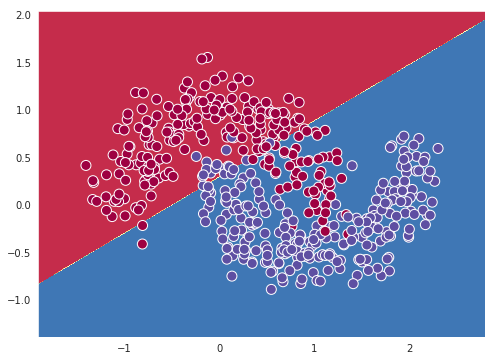

In [5]:
model = Neuron()

lr = 0.1
num_epochs = 30000

history = []
for epoch in range(num_epochs):
    y_hat = model(x[:, -1, :])
    model.backward(y_hat, y[:, -1, :])
    model.update(lr=lr)
    total_loss = np.sum(loss(y_hat, y[:, -1, :])) / size
    predictions = model.predict(x[:, -1, :])
    acc = np.mean(predictions == y[:, -1, :])
    if (epoch + 1) % 5000 == 0:
        print(f'epoch: {epoch+1}/{num_epochs} | loss: {total_loss:.3f} | acc: {acc:.3f}')

# Plot Results
plt.figure(figsize = (8, 6), facecolor = 'w')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01

# Generate a grid
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the value the grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T)
Z = Z.reshape(xx.shape)

# Plot scatter with contour
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral, edgecolors='w', s=100)

## Model with Two Layers

epoch: 5000/30000 | loss: 0.271 | acc: 0.880
epoch: 10000/30000 | loss: 0.156 | acc: 0.948
epoch: 15000/30000 | loss: 0.111 | acc: 0.970
epoch: 20000/30000 | loss: 0.092 | acc: 0.980
epoch: 25000/30000 | loss: 0.082 | acc: 0.980
epoch: 30000/30000 | loss: 0.076 | acc: 0.982


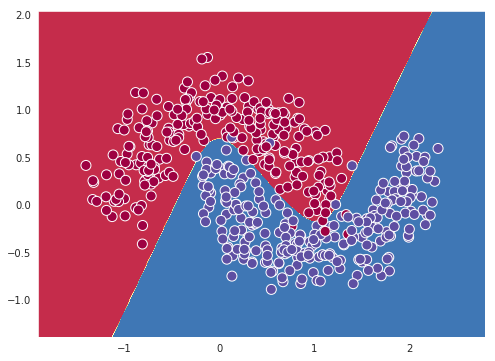

In [6]:
model = TwoLayers()

lr = 0.1
num_epochs = 30000

history = []
for epoch in range(num_epochs):
    y_hat = model(x[:, -1, :])
    model.backward(y_hat, y[:, -1, :])
    model.update(lr=lr)
    total_loss = np.sum(loss(y_hat, y[:, -1, :])) / size
    predictions = model.predict(x[:, -1, :])
    acc = np.mean(predictions == y[:, -1, :])
    if (epoch + 1) % 5000 == 0:
        print(f'epoch: {epoch+1}/{num_epochs} | loss: {total_loss:.3f} | acc: {acc:.3f}')

# Plot Results
plt.figure(figsize = (8, 6), facecolor = 'w')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01

# Generate a grid
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the value the grid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T)
Z = Z.reshape(xx.shape)

# Plot scatter with contour
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral, edgecolors='w', s=100)
